<hr style="height:2px;">

# Demo: Neural network training for *BCM3D 2.0*

This notebook demonstrates training a CARE model for a 3D image transfer task, assuming that training data was already generated via (datagen.ipynb) and has been saved as the file ``training_data.npz``.

In [ ]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE

The TensorFlow backend uses all available GPU memory by default, hence it can be useful to limit it:

In [ ]:
# limit_gpu_memory(fraction=1/2)

<hr style="height:2px;">

# Training data

Load training data generated via datagen.ipynb, use 10% as validation data.

In [2]:
(X,Y), (X_val,Y_val), axes = load_training_data('Data/Training/training_data.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 922
number of validation images:	 102
image size (3D):		 (16, 64, 64)
axes:				 SZYXC
channels in / out:		 1 / 1


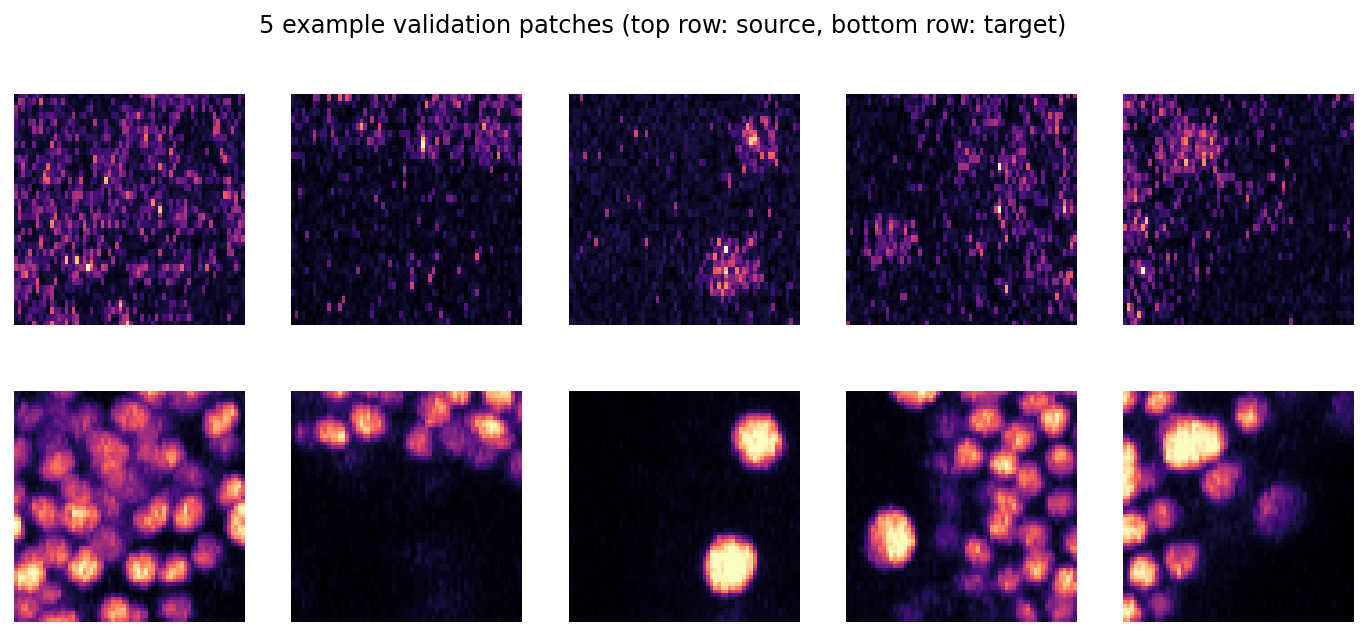

In [3]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

<hr style="height:2px;">

# CARE model

Before we construct the actual CARE model, we have to define its configuration via a `Config` object, which includes 
* parameters of the underlying neural network,
* the learning rate,
* the number of parameter updates per epoch,
* the loss function, and
* whether the model is probabilistic or not.

The defaults should be sensible in many cases, so a change should only be necessary if the training process fails.  

In [4]:
config = Config(axes, n_channel_in, n_channel_out, train_steps_per_epoch=10)
print(config)
vars(config)

Config(axes='ZYXC', n_channel_in=1, n_channel_out=1, n_dim=3, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=10, train_tensorboard=True, unet_input_shape=(None, None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 100,
 'train_steps_per_epoch': 10,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

We now create a CARE model with the chosen configuration (remember change model name and saved folder accordingly, we suggest put meaniful names for your models):

In [ ]:
model = CARE(config, 'my_model', basedir='models')

<hr style="height:2px;">

# Training

Training the model will likely take some time. We recommend to monitor the progress.

In [ ]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Plot final training history (available in TensorBoard during training):

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

<hr style="height:2px;">

# Evaluation

Example results for validation images.

In [ ]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
_P.shape

In [ ]:
Y_val_show = Y_val[:5]
plot_some(X_val[:5],Y_val_show[:,:,:,:,0],_P[:,:,:,:,0],pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target channel 1 (ground truth),  '
             'bottom row: predicted from source channel 1');

plt.figure(figsize=(12,7))
plot_some(X_val[:5],Y_val_show[:,:,:,:,1],_P[:,:,:,:,1],pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target channel 2 (ground truth),  '
             'bottom row: predicted from source channel 2');